입력 데이터 배치 블록 수 설정: 3
학습 횟수 설정: 1000
Epoch: 0, D-loss = 0.6855, G-loss = 0.6868
Epoch: 10, D-loss = 0.6751, G-loss = 0.6880
Epoch: 20, D-loss = 0.6814, G-loss = 0.6941
Epoch: 30, D-loss = 0.6921, G-loss = 0.7049
Epoch: 40, D-loss = 0.6960, G-loss = 0.7056
Epoch: 50, D-loss = 0.6946, G-loss = 0.7150
Epoch: 60, D-loss = 0.6928, G-loss = 0.7152
Epoch: 70, D-loss = 0.6935, G-loss = 0.6917
Epoch: 80, D-loss = 0.6932, G-loss = 0.6929
Epoch: 90, D-loss = 0.6932, G-loss = 0.6958
Epoch: 100, D-loss = 0.6932, G-loss = 0.6924
Epoch: 110, D-loss = 0.6931, G-loss = 0.6937
Epoch: 120, D-loss = 0.6933, G-loss = 0.6926
Epoch: 130, D-loss = 0.6930, G-loss = 0.6961
Epoch: 140, D-loss = 0.6931, G-loss = 0.6914
Epoch: 150, D-loss = 0.6932, G-loss = 0.6938
Epoch: 160, D-loss = 0.6928, G-loss = 0.6933
Epoch: 170, D-loss = 0.6930, G-loss = 0.6950
Epoch: 180, D-loss = 0.6927, G-loss = 0.6943
Epoch: 190, D-loss = 0.6929, G-loss = 0.6938
Epoch: 200, D-loss = 0.6930, G-loss = 0.6929
Epoch: 210, D-loss = 0.6933, G

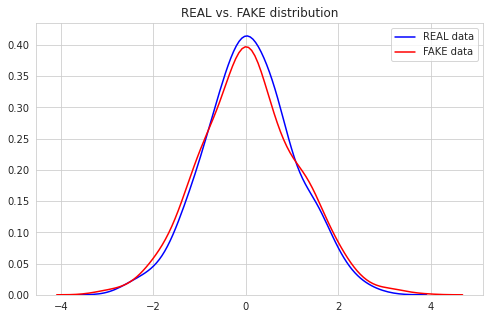

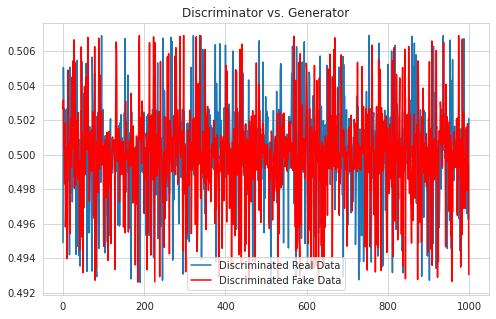

In [ ]:
# 모듈 불러오기
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# eager execution 기능 끄기
tf.compat.v1.disable_eager_execution()

# 실제 데이터 준비
real_data = np.random.normal(size=1000)
real_data = real_data.reshape(real_data.shape[0], 1)

# 가짜 데이터 생성
def makeZ(m, n):
    z = np.random.uniform(-1.0, 1.0, size=[m, n])
    return z

# 모델 파라미터 설정
d_input = real_data.shape[1]
d_hidden = 32
d_output = 1 # 주의
g_input = 16
g_hidden = 32
g_output = d_input # 주의

# 옵티마이저 설정
def myOptimizer(lr):
    return RMSprop(learning_rate=lr)

# Discriminator 모델
def build_D():
    d_x = Input(batch_shape=(None, d_input))
    d_h = Dense(d_hidden, activation='relu')(d_x)
    d_o = Dense(d_output, activation='sigmoid')(d_h)
    
    d_model = Model(d_x, d_o)
    d_model.compile(loss='binary_crossentropy', optimizer=myOptimizer(0.001))
    
    return d_model

# Generator 모델
def build_G():
    g_x = Input(batch_shape=(None, g_input))
    g_h = Dense(g_hidden, activation='relu')(g_x)
    g_o = Dense(g_output, activation='linear')(g_h)
    
    g_model = Model(g_x, g_o)
    
    return g_model

# GAN 네트워크
def build_GAN(discriminator, generator):
    discriminator.trainable = False # discriminator 업데이트 해제
    z = Input(batch_shape=(None, g_input))
    Gz = generator(z) # build한 generator 모델로 만듦.
    DGz = discriminator(Gz) # build한 discriminator 모델로 판별.
    
    gan_model = Model(z, DGz)
    gan_model.compile(loss='binary_crossentropy', optimizer=myOptimizer(0.0005))
    
    return gan_model

# 학습
K.clear_session() # 5) 그래프 초기화

D = build_D() # discriminator 모델 빌드
G = build_G() # generator 모델 빌드
GAN = build_GAN(D, G) # GAN 네트워크 빌드

n_batch_cnt = int(input('입력 데이터 배치 블록 수 설정: '))
n_batch_size = int(real_data.shape[0] / n_batch_cnt)

EPOCHS = int(input('학습 횟수 설정: '))

for epoch in range(EPOCHS):
    # 미니배치 업데이트
    for n in range(n_batch_cnt):
        from_, to_ = n*n_batch_size, (n+1)*n_batch_size
        if n == n_batch_cnt -1 : # 마지막 루프
            to_ = real_data.shape[0]
        
        # 학습 데이터 미니배치 준비
        X_batch = real_data[from_: to_]
        Z_batch = makeZ(m=X_batch.shape[0], n=g_input)
        Gz = G.predict(Z_batch) # 가짜 데이터로부터 분포 생성
        
        # discriminator 학습 데이터 준비
        d_target = np.zeros(X_batch.shape[0]*2)
        d_target[:X_batch.shape[0]] = 0.9 # 1.0보다 성능 향상
        d_target[X_batch.shape[0]:] = 0.1 # 0.0보다 성능 향상
        
        # discriminator 학습
        bX_Gz = np.concatenate([X_batch, Gz]) # 묶어줌.
        loss_D = D.train_on_batch(bX_Gz, d_target) # loss 계산: fit 사용하지 않음.
        
        # generator 학습
        g_target = np.zeros(Z_batch.shape[0])
        g_target[:] = 0.9 # 모두 할당해야 바뀜.
        loss_G = GAN.train_on_batch(Z_batch, g_target)
        
    if epoch % 10 == 0:
        z = makeZ(m=real_data.shape[0], n=g_input)
        fake_data = G.predict(z) # 가짜 데이터 생성: 모델이므로 predict.
        print("Epoch: %d, D-loss = %.4f, G-loss = %.4f" %(epoch, loss_D, loss_G))

# 학습 완료 후 데이터 분포 시각화
z = makeZ(m=real_data.shape[0], n=g_input)
fake_data = G.predict(z)

plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')
sns.kdeplot(real_data[:, 0], color='blue', bw=0.3, label='REAL data')
sns.kdeplot(fake_data[:, 0], color='red', bw=0.3, label='FAKE data')
plt.legend()
plt.title('REAL vs. FAKE distribution')
plt.show()

# 학습 완료 후 discriminator 판별 시각화
d_real_values = D.predict(real_data) # 실제 데이터 판별값
d_fake_values = D.predict(fake_data) # 가짜 데이터 판별값

plt.figure(figsize=(8, 5))
plt.plot(d_real_values, label='Discriminated Real Data')
plt.plot(d_fake_values, label='Discriminated Fake Data', color='red')
plt.title("Discriminator vs. Generator")
plt.legend()
plt.show()

In [ ]:
# GAN model 구조 확인
print(GAN.summary())
print('')
print(G.summary())
print('')
print(D.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
model_1 (Model)              (None, 1)                 577       
_________________________________________________________________
model (Model)                (None, 1)                 97        
Total params: 674
Trainable params: 577
Non-trainable params: 97
_________________________________________________________________
None

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_____________________________________

# 분포를 바꿔 보자.

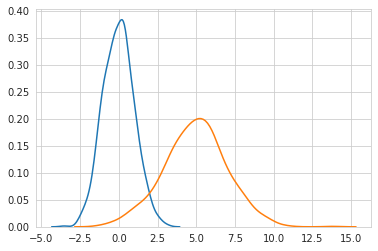

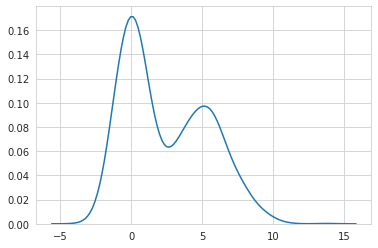

입력 데이터 배치 블록 수 설정: 5
학습 횟수 설정: 1500
Epoch: 0, D-loss = 0.5953, G-loss = 0.7074
Epoch: 10, D-loss = 0.5449, G-loss = 0.7000
Epoch: 20, D-loss = 0.5471, G-loss = 0.7529
Epoch: 30, D-loss = 0.5701, G-loss = 0.7849
Epoch: 40, D-loss = 0.6212, G-loss = 0.7570
Epoch: 50, D-loss = 0.6526, G-loss = 0.7525
Epoch: 60, D-loss = 0.6900, G-loss = 0.7551
Epoch: 70, D-loss = 0.7084, G-loss = 0.7752
Epoch: 80, D-loss = 0.7239, G-loss = 0.7626
Epoch: 90, D-loss = 0.7265, G-loss = 0.7277
Epoch: 100, D-loss = 0.7230, G-loss = 0.6914
Epoch: 110, D-loss = 0.7181, G-loss = 0.6733
Epoch: 120, D-loss = 0.7125, G-loss = 0.6676
Epoch: 130, D-loss = 0.7104, G-loss = 0.6702
Epoch: 140, D-loss = 0.7112, G-loss = 0.6698
Epoch: 150, D-loss = 0.7011, G-loss = 0.6755
Epoch: 160, D-loss = 0.6907, G-loss = 0.6796
Epoch: 170, D-loss = 0.6839, G-loss = 0.6833
Epoch: 180, D-loss = 0.6797, G-loss = 0.6872
Epoch: 190, D-loss = 0.6744, G-loss = 0.6878
Epoch: 200, D-loss = 0.6783, G-loss = 0.6824
Epoch: 210, D-loss = 0.6796, G

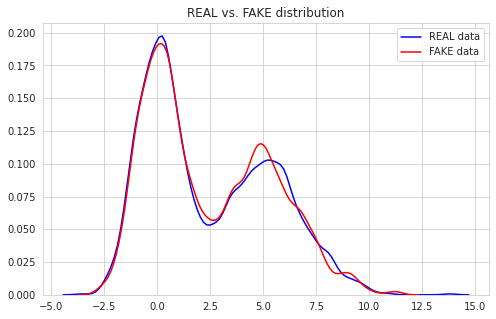

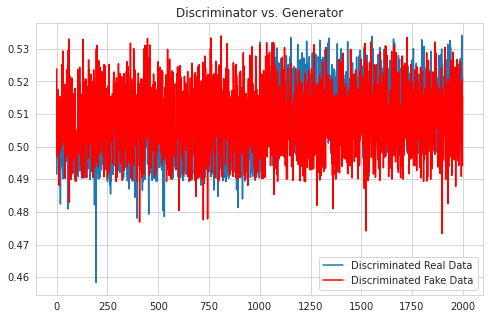

In [25]:
# 실제 데이터 준비
real_data_1 = np.random.normal(size=1000)
real_data_2 = np.random.normal(5, 2, size=1000) # 또 다른 분포
real_data = np.hstack([real_data_1, real_data_2]) # 분포 합치기
real_data = real_data.reshape(real_data.shape[0], 1)

# 확인 위해 그림 그리기
sns.kdeplot(real_data_1.reshape(real_data_1.shape[0], 1)[:, 0])
sns.kdeplot(real_data_2.reshape(real_data_1.shape[0], 1)[:, 0])
plt.show()
sns.kdeplot(real_data[:, 0])
plt.show()

# 가짜 데이터 생성
def makeZ(m, n):
    z = np.random.uniform(-1.0, 1.0, size=[m, n])
    return z

# 모델 파라미터 설정
d_input = real_data.shape[1]
d_hidden = 64
d_output = 1 # 주의
g_input = 32
g_hidden = 64
g_output = d_input # 주의

# 옵티마이저 설정
def myOptimizer(lr):
    return RMSprop(learning_rate=lr)

# Discriminator 모델
def build_D():
    d_x = Input(batch_shape=(None, d_input))
    d_h = Dense(d_hidden, activation='relu')(d_x)
    d_o = Dense(d_output, activation='sigmoid')(d_h)
    
    d_model = Model(d_x, d_o)
    d_model.compile(loss='binary_crossentropy', optimizer=myOptimizer(0.001))
    
    return d_model

# Generator 모델
def build_G():
    g_x = Input(batch_shape=(None, g_input))
    g_h = Dense(g_hidden, activation='relu')(g_x)
    g_o = Dense(g_output, activation='linear')(g_h)
    
    g_model = Model(g_x, g_o)
    
    return g_model

# GAN 네트워크
def build_GAN(discriminator, generator):
    discriminator.trainable = False # discriminator 업데이트 해제
    z = Input(batch_shape=(None, g_input))
    Gz = generator(z) # build한 generator 모델로 만듦.
    DGz = discriminator(Gz) # build한 discriminator 모델로 판별.
    
    gan_model = Model(z, DGz)
    gan_model.compile(loss='binary_crossentropy', optimizer=myOptimizer(0.0005))
    
    return gan_model

# 학습
K.clear_session() # 그래프 초기화

D = build_D() # discriminator 모델 빌드
G = build_G() # generator 모델 빌드
GAN = build_GAN(D, G) # GAN 네트워크 빌드

n_batch_cnt = int(input('입력 데이터 배치 블록 수 설정: '))
n_batch_size = int(real_data.shape[0] / n_batch_cnt)

EPOCHS = int(input('학습 횟수 설정: '))

for epoch in range(EPOCHS):
    # 미니배치 업데이트
    for n in range(n_batch_cnt):
        from_, to_ = n*n_batch_size, (n+1)*n_batch_size
        if n == n_batch_cnt -1 : # 마지막 루프
            to_ = real_data.shape[0]
        
        # 학습 데이터 미니배치 준비
        X_batch = real_data[from_: to_]
        Z_batch = makeZ(m=X_batch.shape[0], n=g_input)
        Gz = G.predict(Z_batch) # 가짜 데이터로부터 분포 생성
        
        # discriminator 학습 데이터 준비
        d_target = np.zeros(X_batch.shape[0]*2)
        d_target[:X_batch.shape[0]] = 0.9 # 1.0보다 성능 향상
        d_target[X_batch.shape[0]:] = 0.1 # 0.0보다 성능 향상
        
        # discriminator 학습
        bX_Gz = np.concatenate([X_batch, Gz]) # 묶어줌.
        loss_D = D.train_on_batch(bX_Gz, d_target) # loss 계산: fit 사용하지 않음.
        
        # generator 학습
        g_target = np.zeros(Z_batch.shape[0])
        g_target[:] = 0.9 # 모두 할당해야 바뀜.
        loss_G = GAN.train_on_batch(Z_batch, g_target)
        
    if epoch % 10 == 0:
        z = makeZ(m=real_data.shape[0], n=g_input)
        fake_data = G.predict(z) # 가짜 데이터 생성: 모델이므로 predict.
        print("Epoch: %d, D-loss = %.4f, G-loss = %.4f" %(epoch, loss_D, loss_G))

# 학습 완료 후 데이터 분포 시각화
z = makeZ(m=real_data.shape[0], n=g_input)
fake_data = G.predict(z)

plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')
sns.kdeplot(real_data[:, 0], color='blue', bw=0.3, label='REAL data')
sns.kdeplot(fake_data[:, 0], color='red', bw=0.3, label='FAKE data')
plt.legend()
plt.title('REAL vs. FAKE distribution')
plt.show()

# 학습 완료 후 discriminator 판별 시각화
d_real_values = D.predict(real_data) # 실제 데이터 판별값
d_fake_values = D.predict(fake_data) # 가짜 데이터 판별값

plt.figure(figsize=(8, 5))
plt.plot(d_real_values, label='Discriminated Real Data')
plt.plot(d_fake_values, label='Discriminated Fake Data', color='red')
plt.title("Discriminator vs. Generator")
plt.legend()
plt.show()